In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [38]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [39]:
import matplotlib.pyplot as plt
from PIL import Image
import time
import functools
from io import BytesIO
import requests

In [40]:
content_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Einstein_1921_by_F_Schmutzer_-_restoration.jpg/220px-Einstein_1921_by_F_Schmutzer_-_restoration.jpg"
style_path = "https://www.vangoghgallery.com/img/starry_night_full.jpg"

In [41]:

def load_img(img_path):
    
    max_dim = 512
    img = Image.open(BytesIO(requests.get(img_path).content))
    k = max(img.size)
    scale = max_dim/k
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS) # Image.ANTIALIAS - High-quality downsampling filter
    
    img = kp_image.img_to_array(img) # Converts a PIL Image instance to a Numpy array
    
    img = np.expand_dims(img , axis = 0) # To expand the shape of an array
    
    return img
    
    
    

In [42]:
def imshow(img, title=None):
    out = np.squeeze(img, axis=0) # To Remove single-dimensional entries from the shape of an array
    # Normalize for display
    out = out.astype('uint8') # Unsigned integers of 8 bits (0 - 255)
    plt.imshow(out)
    if title is not None: # Check if plot title is passed
        plt.title(title)
    plt.imshow(out)

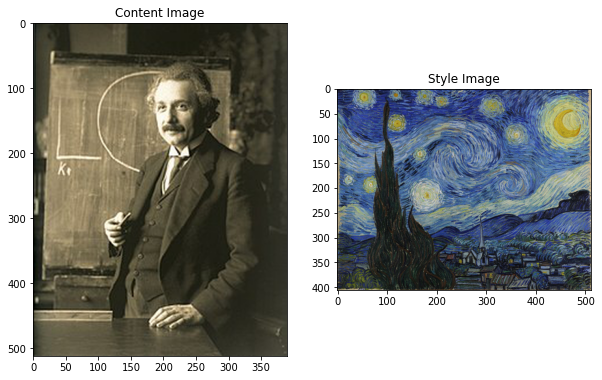

In [43]:

plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()


######################### SEE IF I NEED TO RESHAPE TO SAME SIZES

In [44]:
#Loading the image to the VGG19 network
#VGG networks are trained on images with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels as BGR rather than RGB

def load_and_process_img(img_path):
    img = load_img(img_path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img



In [45]:
# To view the image we have to do the reverese of the above steps , 

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of ""dimension [1, height, width, channel] or [height, width, channel]")
    
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    # perform the inverse of the preprocessiing step to convert back to original  values
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8') # np.clip -- values smaller than 0 --> 0, greater than 255 --> 255
    return x

In [46]:

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [47]:

def get_model():
    
    vgg = tf.keras.applications.vgg19.VGG19(include_top = False , weights = 'imagenet') 
    # 'include_top = False' --> the 3 first fully conected layers at the top of the network are not connected
    # weights for the network are taken from pretrained imagenet network
    
    vgg.trainable = False  # since we are not training the network
    
    style_outputs = [vgg.get_layer(i).output for i in style_layers]
    content_outputs = [vgg.get_layer(i).output for i in content_layers]
    
    model_outputs =  style_outputs + content_outputs
    
    # Build the model
    return models.Model(vgg.input , model_outputs)
    
    

In [48]:
def get_content_loss(content, target):
    
    return tf.reduce_mean(tf.square(content - target))

In [49]:

def gram_matrix(input_tensor):
 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(style_image, gram_target):

    height, width, channels = style_image.get_shape().as_list() # to get height , width , no of channels of style image
    gram_style = gram_matrix(style_image)
  
    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [50]:

###############################################################################################
def get_feature_representations(model , content_path , style_path):
    
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    content_outputs = model(content_image)
    style_outputs = model(style_image)
    
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    
    return style_features,content_features

In [51]:

    
####################################change weights for style and content HERE ########################################
def compute_loss(model , loss_weights , initial_image , gram_style_features , content_features):
    
    style_weight, content_weight = loss_weights
    
    model_outputs = model(initial_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    ##### For Style losses
    
    w_layer = 1.0 / float(num_style_layers)
    for target_style , comb_style in zip(gram_style_features, style_output_features):
        style_score += w_layer * get_style_loss(comb_style[0], target_style)
        
    w_layer = 1.0 / float(num_content_layers)
    for target_content , comb_content in zip(content_features, content_output_features):
        content_score += w_layer * get_content_loss(comb_content[0], target_content)
        
    style_score *= style_weight
    content_score *= content_weight
    
    loss = style_score + content_score 
    
    return loss , style_score , content_score
    
    
        
        
    



In [52]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['initial_image']), all_loss

In [53]:

import IPython.display

def run_style_transfer(content_path, style_path,num_iterations=1000,content_weight=1e3, style_weight=1e-2): 

    model = get_model() 
    for layer in model.layers:
        layer.trainable = False


    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    #initial image
    initial_image = load_and_process_img(content_path)
    initial_image = tf.Variable(initial_image, dtype=tf.float32)
    
    #optimizer
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    iter_count = 1

    # best results
    best_loss, best_img = float('inf'), None

    
    loss_weights = (style_weight, content_weight)
    cfg = {'model': model , 'loss_weights': loss_weights , 'initial_image': initial_image , 'gram_style_features': gram_style_features , 'content_features': content_features }

  

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    display_interval = 250
    

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, initial_image)])
        clipped = tf.clip_by_value(initial_image, min_vals, max_vals)
        initial_image.assign(clipped)
        end_time = time.time() 

            

        if loss < best_loss:
          
            best_loss = loss
            best_img = deprocess_img(initial_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            
            plot_img = initial_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 'style loss: {:.4e}, ''content loss: {:.4e}, ''time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    return best_img, best_loss

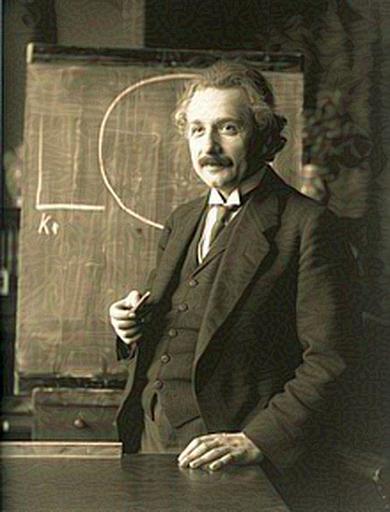

Iteration: 0
Total loss: 2.1528e+08, style loss: 2.1528e+08, content loss: 0.0000e+00, time: 0.0902s


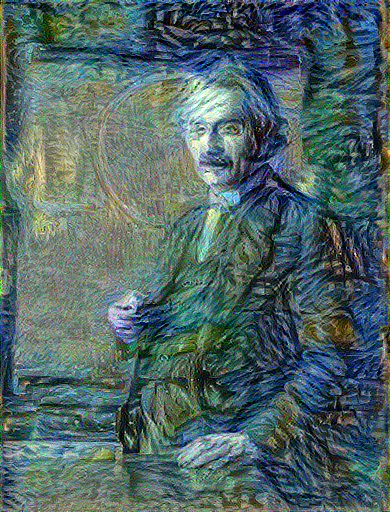

Iteration: 250
Total loss: 1.3910e+06, style loss: 6.8253e+05, content loss: 7.0848e+05, time: 0.0517s


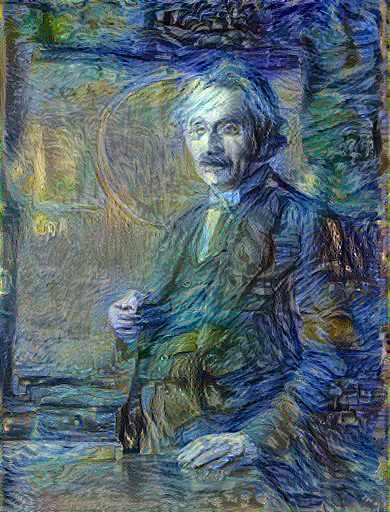

Iteration: 500
Total loss: 6.6840e+05, style loss: 2.4044e+05, content loss: 4.2797e+05, time: 0.0522s


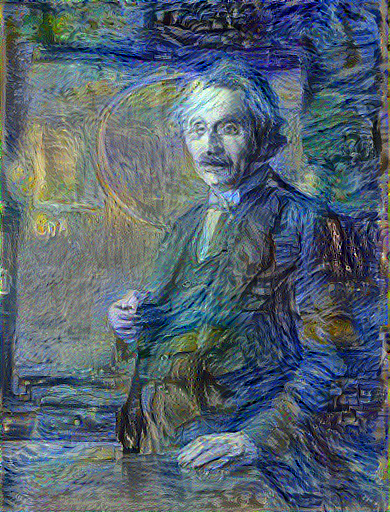

Iteration: 750
Total loss: 5.1054e+05, style loss: 1.7309e+05, content loss: 3.3744e+05, time: 0.0648s


In [54]:

best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

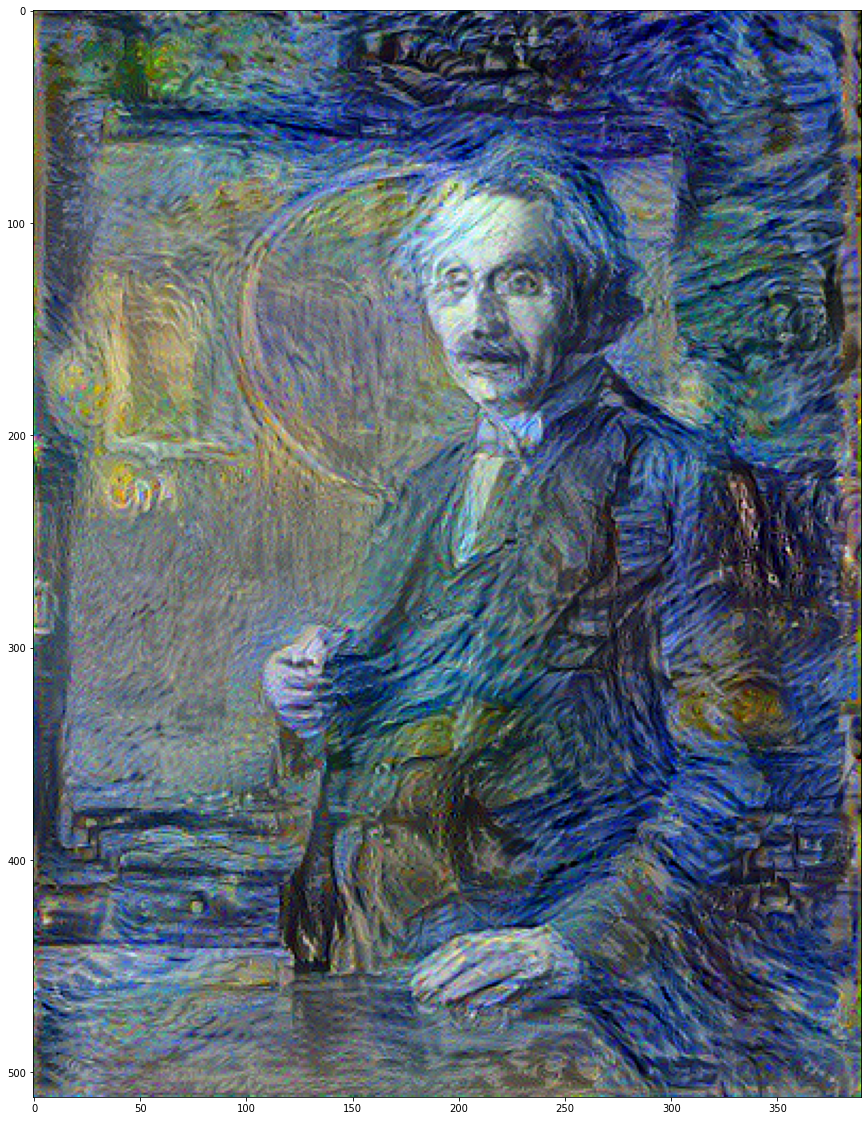

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(best)